<a href="https://colab.research.google.com/github/AnaghaTantry/ML-project/blob/main/ESR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
# from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
import keras
from matplotlib.pyplot import figure
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Epileptic Seizure Recognition.csv')

In [ ]:
data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [ ]:
data = data.values
data = data[1:11501, 1:180]
#data[:, 178] = data[:, 178].astype(int)
data.shape

(11499, 179)

In [ ]:
D = data
df_1 = D[D[:, 178]==1]
df_2 = D[D[:, 178]==2]
df_3 = D[D[:, 178]==3]
df_4 = D[D[:, 178]==4]
df_5 = D[D[:, 178]==5]

print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

df_1 = df_1.astype(int)
df_2 = df_2.astype(int)
df_3 = df_3.astype(int)
df_4 = df_4.astype(int)
df_5 = df_5.astype(int)

(2300, 179)
(2300, 179)
(2300, 179)
(2299, 179)
(2300, 179)


In [ ]:
df_3[:, 178] = df_3[:, 178] - 3
D1 = np.concatenate([df_1, df_3])

In [ ]:
number_of_rows = D1.shape[0]

random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.8), replace=False)

label_train = D1[random_indices, -1]
data_train = D1[random_indices, :-1]

D1_rest = np.delete(D1, random_indices, 0)

number_of_rows = D1_rest.shape[0]
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.5), replace=False)

label_val = D1_rest[random_indices, -1]
data_val = D1_rest[random_indices, :-1]

D1_rest_rest = np.delete(D1_rest, random_indices, 0)
label_test = D1_rest_rest[:, -1]
data_test = D1_rest_rest[:, :-1]

data_train = np.expand_dims(data_train, axis=2)
data_val = np.expand_dims(data_val, axis=2)
data_test = np.expand_dims(data_test, axis=2)

print(label_train.shape, data_train.shape)
print(label_val.shape, data_val.shape)
print(label_test.shape, data_test.shape)

(3680,) (3680, 178, 1)
(460,) (460, 178, 1)
(460,) (460, 178, 1)


In [ ]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model - Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['1','2', '3']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

#This is where we define how we evaluate the model

In [ ]:
# Defining CNN network
def network_CNN(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1d_1 = layers.Conv1D(filters=32, kernel_size=6)(inputs_cnn)
    batch_normalization = BatchNormalization()(conv1d_1)
    max_pooling1d = layers.MaxPooling1D( 2, padding='same')(batch_normalization)
    conv1d_2 = layers.Conv1D(filters=64, kernel_size=3)(max_pooling1d)
    batch_normalization_1 = BatchNormalization()(conv1d_2)
    max_pooling1d_1 = layers.MaxPooling1D(2, padding='same')(batch_normalization_1)
    flatten = Flatten()(max_pooling1d_1)
    dense = Dense(32)(flatten)
    dense_1 = Dense(16)(dense)
    main_output = Dense(2)(dense_1)
    model1 = Model(inputs= inputs_cnn, outputs=main_output)
    model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model1)

In [ ]:
model1 = network_CNN(data_train,label_train)
print(model1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 178, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 173, 32)           224       
                                                                 
 batch_normalization (Batch  (None, 173, 32)           128       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 87, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 85, 64)            6208      
                                                                 
 batch_normalization_1 (Bat  (None, 85, 64)            256   

In [ ]:
save_path = '/tmp/checkpoint_1'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model1.fit(data_train, label_train,epochs=100, batch_size=32, validation_data=(data_val,label_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
115/115 [==============================] - 14s 21ms/step - loss: 0.9050 - accuracy: 0.8326 - val_loss: 1.0044 - val_accuracy: 0.6152
Epoch 2/100
115/115 [==============================] - 2s 14ms/step - loss: 0.5718 - accuracy: 0.7204 - val_loss: 0.5752 - val_accuracy: 0.6609
Epoch 3/100
115/115 [==============================] - 2s 16ms/step - loss: 0.5571 - accuracy: 0.7212 - val_loss: 0.6041 - val_accuracy: 0.6739
Epoch 4/100
115/115 [==============================] - 1s 10ms/step - loss: 0.5992 - accuracy: 0.7220 - val_loss: 0.6479 - val_accuracy: 0.8087
Epoch 5/100
115/115 [==============================] - 1s 10ms/step - loss: 0.6336 - accuracy: 0.8073 - val_loss: 0.6464 - val_accuracy: 0.8109
Epoch 6/100
115/115 [==============================] - 1s 8ms/step - loss: 0.6363 - accuracy: 0.7543 - val_loss: 0.6329 - val_accuracy: 0.7565
Epoch 7/100
115/115 [==============================] - 1s 10ms/step - loss: 0.6289 - accuracy: 0.7125 - val_loss: 0.6344 - val_accuracy:

Accuracy: 45.87%


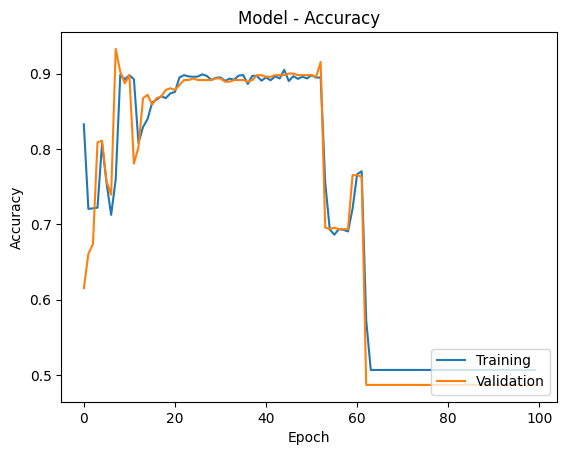

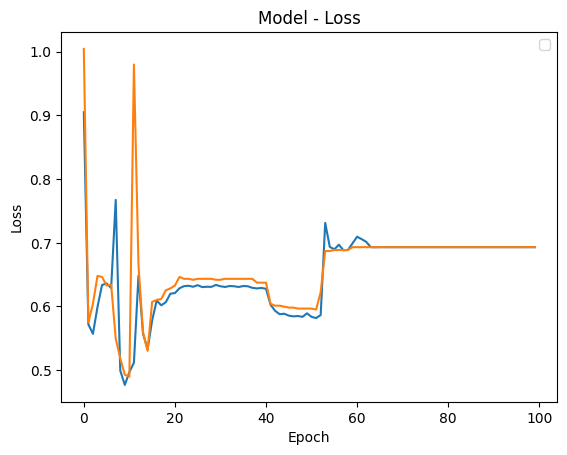

15/15 [==============================] - 0s 2ms/step


In [ ]:
evaluate_model(history,data_test,label_test,model1)
y_pred=model1.predict(data_test)

Accuracy: 92.83%


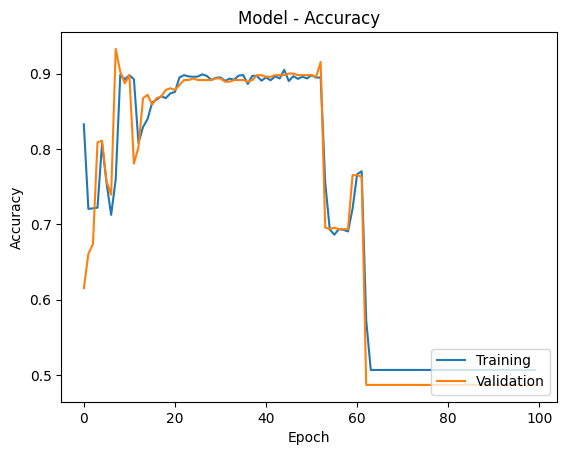

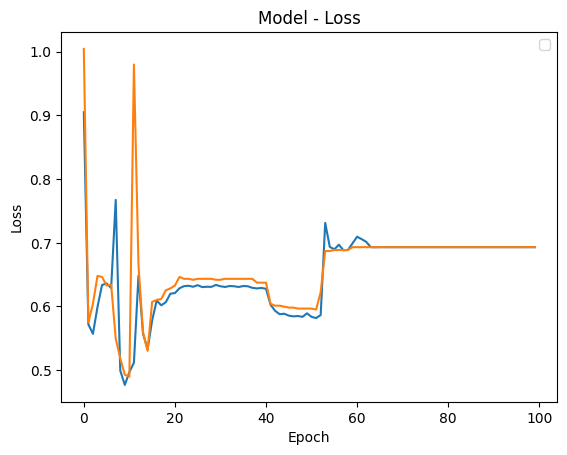

15/15 [==============================] - 0s 2ms/step


In [ ]:
model1.load_weights(save_path)
evaluate_model(history,data_test,label_test,model1)

In [ ]:
# Defining Bidirectional LSTM model
def network_LSTM(X_train,y_train):
    im_shape=(X_train.shape[1],1)
    inputs_lstm=Input(shape=(im_shape), name='inputs_lstm')

    dense = Dense(units=32, activation='relu', name='dense')(inputs_lstm)
    lstm = layers.Bidirectional(LSTM(units=128, name='lstm'))(dense)
    dropout = Dropout(0.3)(lstm)
    batch_normalization = BatchNormalization(name='batch_normalization')(dropout)
    dense_1 = Dense(units=64, activation='relu', name='dense_1')(batch_normalization)
    dropout_2 = Dropout(0.3, name='dropout_2')(dense_1)
    batch_normalization_1 = BatchNormalization(name='batch_normalization_1')(dropout_2)
    main_output = Dense(units=2, activation='softmax')(batch_normalization_1)

    model = Model(inputs= inputs_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

    return(model)

In [ ]:
model2 = network_LSTM(data_train, label_train)
print(model2.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_lstm (InputLayer)    [(None, 178, 1)]          0         
                                                                 
 dense (Dense)               (None, 178, 32)           64        
                                                                 
 bidirectional (Bidirection  (None, 256)               164864    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                1644

In [ ]:
# Training BiLSTM model on epileptic vs all data
# Save model at highest validation accuracy
save_path = '/tmp/checkpoint_2'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history2 = model2.fit(data_train, label_train,epochs=100, batch_size=32, validation_data=(data_val,label_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
115/115 [==============================] - 9s 34ms/step - loss: 0.2398 - accuracy: 0.9043 - val_loss: 0.1422 - val_accuracy: 0.9478
Epoch 2/100
115/115 [==============================] - 2s 18ms/step - loss: 0.1523 - accuracy: 0.9438 - val_loss: 0.1125 - val_accuracy: 0.9587
Epoch 3/100
115/115 [==============================] - 2s 17ms/step - loss: 0.1532 - accuracy: 0.9481 - val_loss: 0.0926 - val_accuracy: 0.9717
Epoch 4/100
115/115 [==============================] - 2s 18ms/step - loss: 0.1201 - accuracy: 0.9587 - val_loss: 0.0742 - val_accuracy: 0.9739
Epoch 5/100
115/115 [==============================] - 2s 17ms/step - loss: 0.1365 - accuracy: 0.9524 - val_loss: 0.0759 - val_accuracy: 0.9739
Epoch 6/100
115/115 [==============================] - 3s 22ms/step - loss: 0.1062 - accuracy: 0.9668 - val_loss: 0.0960 - val_accuracy: 0.9674
Epoch 7/100
115/115 [==============================] - 3s 23ms/step - loss: 0.1320 - accuracy: 0.9576 - val_loss: 0.0772 - val_accuracy:

Accuracy: 96.74%


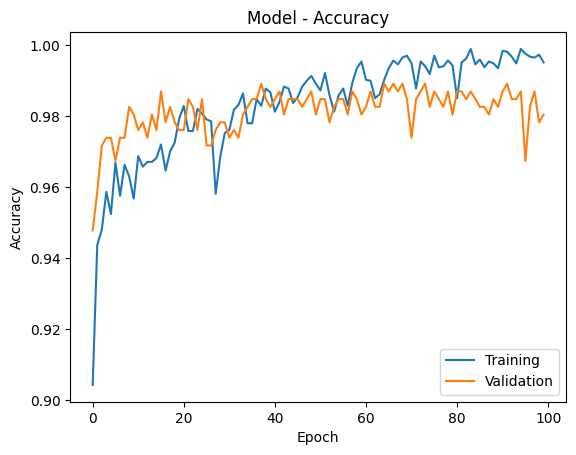

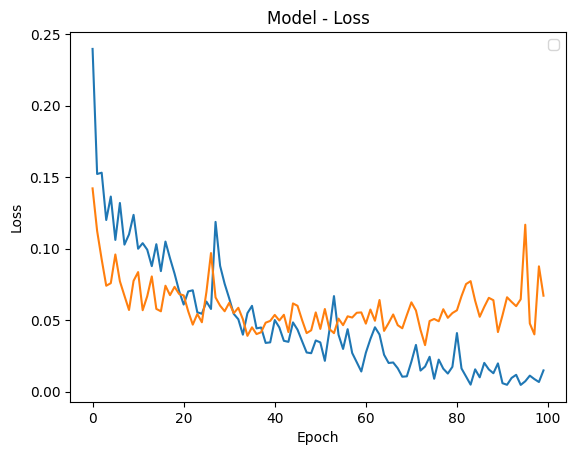

15/15 [==============================] - 1s 8ms/step


In [ ]:
evaluate_model(history2,data_test,label_test,model2)

Accuracy: 98.48%


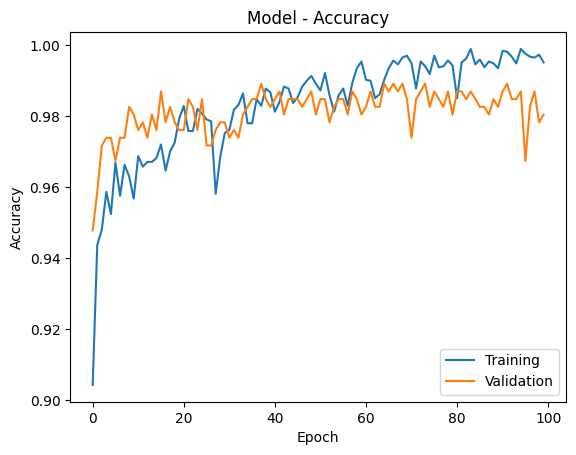

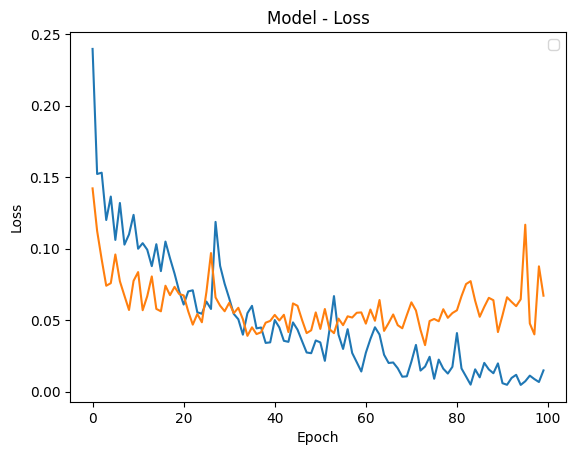

15/15 [==============================] - 0s 7ms/step


In [ ]:
model2.load_weights(save_path)
evaluate_model(history2,data_test,label_test,model2)

In [ ]:
#Comparing CNN and BiLSTM on Epilepsy versus All Other Data Categories
# Defining the data categories
D = data
df_1 = D[D[:, 178]==1]
df_2 = D[D[:, 178]==2]
df_3 = D[D[:, 178]==3]
df_4 = D[D[:, 178]==4]
df_5 = D[D[:, 178]==5]

print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

df_1 = df_1.astype(int)
df_2 = df_2.astype(int)
df_3 = df_3.astype(int)
df_4 = df_4.astype(int)
df_5 = df_5.astype(int)

(2300, 179)
(2300, 179)
(2300, 179)
(2299, 179)
(2300, 179)


In [ ]:
# Concatenating 4 categories into 1 data set
df_2[:, 178] = df_2[:, 178] - 2
df_3[:, 178] = df_3[:, 178] - 3
df_4[:, 178] = df_4[:, 178] - 4
df_5[:, 178] = df_5[:, 178] - 5

D2 = np.concatenate([df_1, df_2, df_3, df_4, df_5])

In [ ]:
number_of_rows = D2.shape[0]

random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.8), replace=False)

label_train_all = D2[random_indices, -1]
data_train_all = D2[random_indices, :-1]

D2_rest = np.delete(D2, random_indices, 0)

number_of_rows = D2_rest.shape[0]
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*0.5), replace=False)

label_val_all = D2_rest[random_indices, -1]
data_val_all = D2_rest[random_indices, :-1]

D2_rest_rest = np.delete(D2_rest, random_indices, 0)
label_test_all = D2_rest_rest[:, -1]
data_test_all = D2_rest_rest[:, :-1]

data_train_all = np.expand_dims(data_train_all, axis=2)
data_val_all = np.expand_dims(data_val_all, axis=2)
data_test_all = np.expand_dims(data_test_all, axis=2)

print(label_train_all.shape, data_train_all.shape)
print(label_val_all.shape, data_val_all.shape)
print(label_test_all.shape, data_test_all.shape)


(9199,) (9199, 178, 1)
(1150,) (1150, 178, 1)
(1150,) (1150, 178, 1)


In [ ]:
# Defining CNN model to be trained on epileptic vs all data
model3 = network_CNN(data_train_all,label_train_all)
print(model3.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 178, 1)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 173, 32)           224       
                                                                 
 batch_normalization_2 (Bat  (None, 173, 32)           128       
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 87, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 85, 64)            6208      
                                                                 
 batch_normalization_3 (Bat  (None, 85, 64)            256 

In [ ]:
# Training CNN model on epileptic vs all data
# Save model at highest validation accuracy
save_path = '/tmp/checkpoint_3'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history3 = model3.fit(data_train_all, label_train_all,epochs=100, batch_size=32, validation_data=(data_val_all,label_val_all), callbacks=[model_checkpoint_callback])

Epoch 1/100
288/288 [==============================] - 4s 7ms/step - loss: 0.8021 - accuracy: 0.6887 - val_loss: 0.6895 - val_accuracy: 0.6026
Epoch 2/100
288/288 [==============================] - 2s 6ms/step - loss: 0.6944 - accuracy: 0.5909 - val_loss: 0.6871 - val_accuracy: 0.6096
Epoch 3/100
288/288 [==============================] - 2s 6ms/step - loss: 0.6911 - accuracy: 0.5688 - val_loss: 0.6865 - val_accuracy: 0.6087
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - loss: 0.7995 - accuracy: 0.5489 - val_loss: 0.7224 - val_accuracy: 0.6165
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - loss: 0.6965 - accuracy: 0.5864 - val_loss: 0.6922 - val_accuracy: 0.6252
Epoch 6/100
288/288 [==============================] - 2s 6ms/step - loss: 0.6940 - accuracy: 0.3651 - val_loss: 0.6931 - val_accuracy: 0.2522
Epoch 7/100
288/288 [==============================] - 2s 6ms/step - loss: 0.6931 - accuracy: 0.2177 - val_loss: 0.6925 - val_accuracy: 0.2470

Accuracy: 19.39%


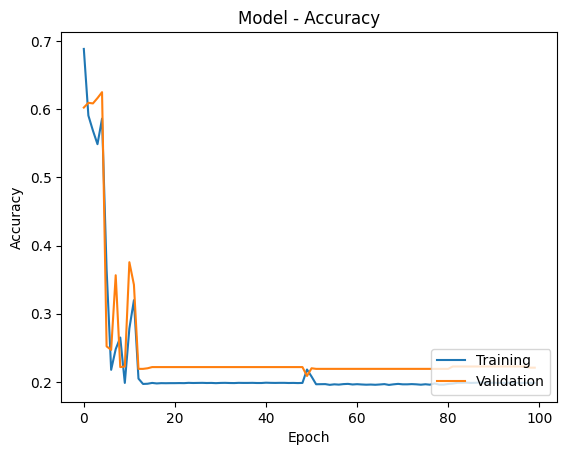

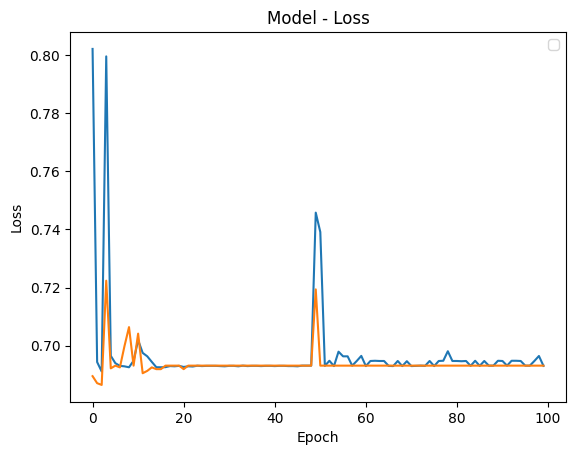

36/36 [==============================] - 0s 2ms/step


In [ ]:
# Printing validation accuracy and plot accuracy and loss
evaluate_model(history3, data_test_all, label_test_all, model3)

Accuracy: 67.04%


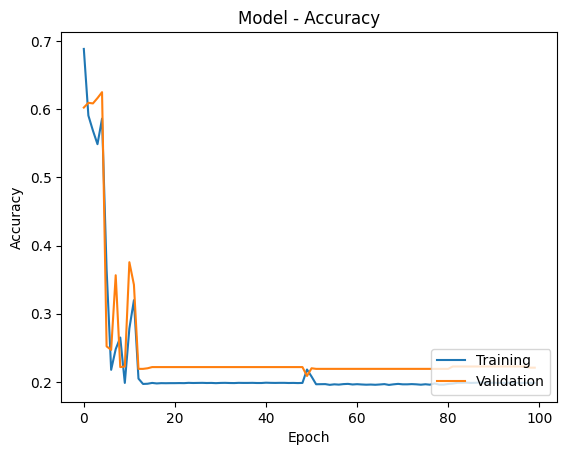

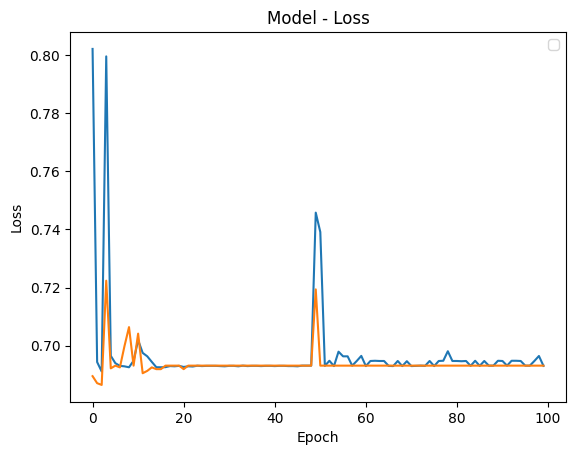

36/36 [==============================] - 0s 2ms/step


In [ ]:
# Printing validation accuracy and plot accuracy and loss for the model's best version
model3.load_weights(save_path)
evaluate_model(history3, data_test_all, label_test_all, model3)

In [ ]:
# Defining BiLSTM model to be trained on epileptic vs all data
model4 = network_LSTM(data_train_all,label_train_all)
print(model4.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_lstm (InputLayer)    [(None, 178, 1)]          0         
                                                                 
 dense (Dense)               (None, 178, 32)           64        
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               164864    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                1644

In [ ]:
# Training BiLSTM model on epileptic vs all data
# Save model at highest validation accuracy
save_path = '/tmp/checkpoint_4'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history4 = model4.fit(data_train_all, label_train_all,epochs=100, batch_size=32, validation_data=(data_val_all,label_val_all), callbacks=[model_checkpoint_callback])

Epoch 1/100
288/288 [==============================] - 12s 23ms/step - loss: 0.3066 - accuracy: 0.8822 - val_loss: 0.2439 - val_accuracy: 0.9139
Epoch 2/100
288/288 [==============================] - 5s 17ms/step - loss: 0.1970 - accuracy: 0.9303 - val_loss: 0.1427 - val_accuracy: 0.9452
Epoch 3/100
288/288 [==============================] - 6s 22ms/step - loss: 0.1621 - accuracy: 0.9401 - val_loss: 0.1295 - val_accuracy: 0.9504
Epoch 4/100
288/288 [==============================] - 6s 21ms/step - loss: 0.1467 - accuracy: 0.9465 - val_loss: 0.1216 - val_accuracy: 0.9530
Epoch 5/100
288/288 [==============================] - 6s 20ms/step - loss: 0.1348 - accuracy: 0.9517 - val_loss: 0.1391 - val_accuracy: 0.9513
Epoch 6/100
288/288 [==============================] - 5s 17ms/step - loss: 0.1320 - accuracy: 0.9533 - val_loss: 0.1117 - val_accuracy: 0.9548
Epoch 7/100
288/288 [==============================] - 5s 17ms/step - loss: 0.1184 - accuracy: 0.9570 - val_loss: 0.1124 - val_accuracy

Accuracy: 98.52%


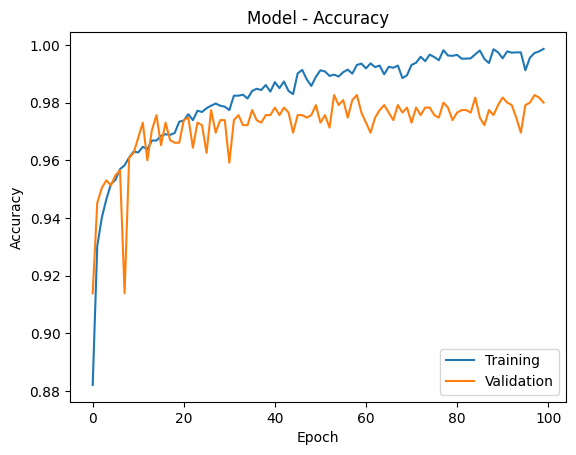

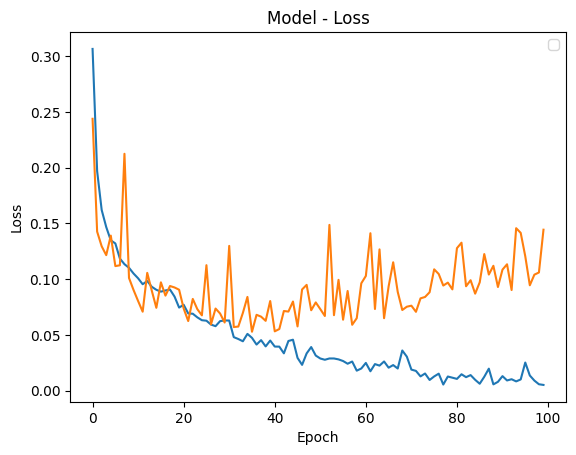

36/36 [==============================] - 1s 6ms/step


In [ ]:
# Printing validation accuracy and plot accuracy and loss
evaluate_model(history4, data_test_all, label_test_all, model4)

Accuracy: 98.26%


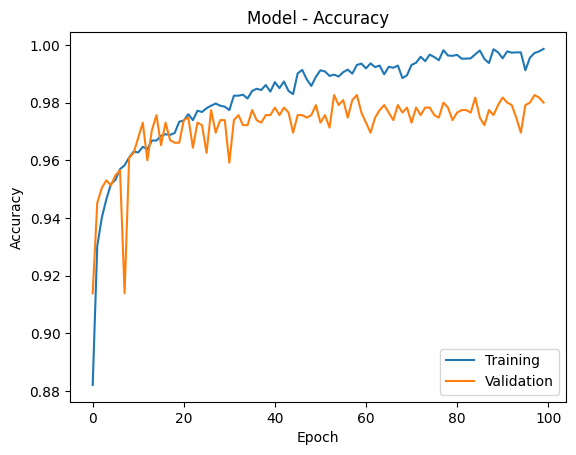

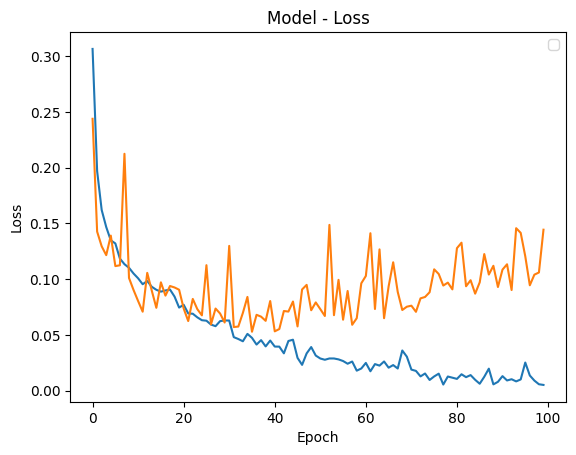

36/36 [==============================] - 0s 6ms/step


In [ ]:
# Printing validation accuracy and plot accuracy and loss for the model's best version
model4.load_weights(save_path)
evaluate_model(history4, data_test_all, label_test_all, model4)